### Imports

In [1]:
import glob
import cv2
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from moviepy.editor import VideoFileClip

### Helper Functions from Project One

In [2]:
def calculate_mask_colors_hls():
    """Calculate colors in HLS used for defining a color mask
    """
    # Show the three components of the color yellow in the HLS color space
    # To turn this color into a range for masking, +/- 10 to the Hue value
    # for the Hue range and set a range 100-255 for the Lightness and 
    # Saturation values
    yellow = np.uint8([[[255,255,0 ]]])
    hls_yellow = cv2.cvtColor(yellow,cv2.COLOR_RGB2HLS)
    print (hls_yellow)

    # Show the three components of the color white in the HLS color space
    # The normal approach to turn a color into a range doesn't work here since
    # white isn't really a color. Looking at an HLS color cylinder we can see
    # that the Hue and Saturation don't really matter as any high Light value 
    # is essentially white. We can see this with the result of the code below
    # [0, 255, 0] (No Hue, 100% Light, No Saturation). To turn this into a range
    # use 0-255 for the Hue, 200-255 for the Light and 0-255 for the Saturation,
    # increasing the lower Light value to increase the sensitivity
    white = np.uint8([[[255,255,255 ]]])
    hls_white = cv2.cvtColor(white,cv2.COLOR_RGB2HLS)
    print (hls_white)

def mask_colors_hls(img):
    """Given an image in HLS space, mask the white and yellow color ranges for 
    lane isolation
    """
    
    # See calculate_mask_colors_hls() above for deriving ranges in HLS color space
    # white mask
    lower = np.uint8([0, 200, 0])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(img, lower, upper)
    
    # yellow mask
    lower = np.uint8([ 15, 100, 100])
    upper = np.uint8([ 45, 255, 255])
    yellow_mask = cv2.inRange(img, lower, upper)
    
    # combined mask
    combined = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = combined)

def process_image_plot(item, ax, mplot):
    """plot an image using the given axis and plot reference
    
    Args:
        item -- item holding image data to be ploted
        ax -- axis reference that can be used to modify the plot
        mplot -- reference to matplotlib that can be used to plot the image
    """    
    ax.set_xticks([]) # remove horizontal ticks from image
    ax.set_yticks([]) # remove vertical ticks from image
    mplot.imshow(item[0], cmap=item[1]) # display image with specified cmap

def tile_images(images, col_num):
    """Plot multiple images in a single image
    
    Args:
        images -- array of images to plot
        col_num -- number of required columns in the plot
    """
    # determine image size to calculate desired figure height
    shape = images[0][0].shape
    img_height = float(shape[0])
    img_width = float(shape[1])
    tile_plots(images, col_num, img_width, img_height, process_image_plot)

def tile_plots(items, col_num, item_width, item_height, processor):
    """Plot multiple items in a single image, each item is processed using the 
    given processor function. The processor function takes as arguments 
    an item, axis and plot reference. It's up to the processor to define how to
    use the axis and plot object to plot the item.
    
    Args:
        items -- array of objects to be processed and ploted in each cell of the figure
        col_num -- number of required columns in the plot
        item_width -- original width of the item, used to retain aspect ratio
        item_height -- original width of the item, used to retain aspect ratio
        processor -- function which takes an item, axis and plot reference and uses
            the axis and plot reference to plot the item
    """
    if len(items) == 0:
        return
    notebook_pixel_width = 900.0
    col_width = notebook_pixel_width / float(col_num)
    row_height = (col_width / item_width) * item_height
    # divide images by required columns to determine number of rows
    row_num = math.ceil(len(items)/col_num)
    fig = plt.figure()
    # figure size is specified in inches, so divide required pixel size by dots per inch
    dpi = fig.get_dpi()
    fig.set_size_inches(notebook_pixel_width/float(dpi), (row_num*row_height)/float(dpi))
    # create a grid layout to position the individual plots
    gridspec.GridSpec(row_num ,col_num)
    for i, item in enumerate(items):
        row = i // col_num # integer floor divide to increment row after all columns
        col = i % col_num # increment col from 0 to cols-1 and cycle back to 0
        ax = plt.subplot2grid((row_num, col_num), (row, col)) # create plot in correct grid cell
        processor(item, ax, plt)
        plt.tight_layout() # remove margins from figure
        
    plt.show()
    
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

# Camera Calibration

Number of calibration images where corners could not be found: 3


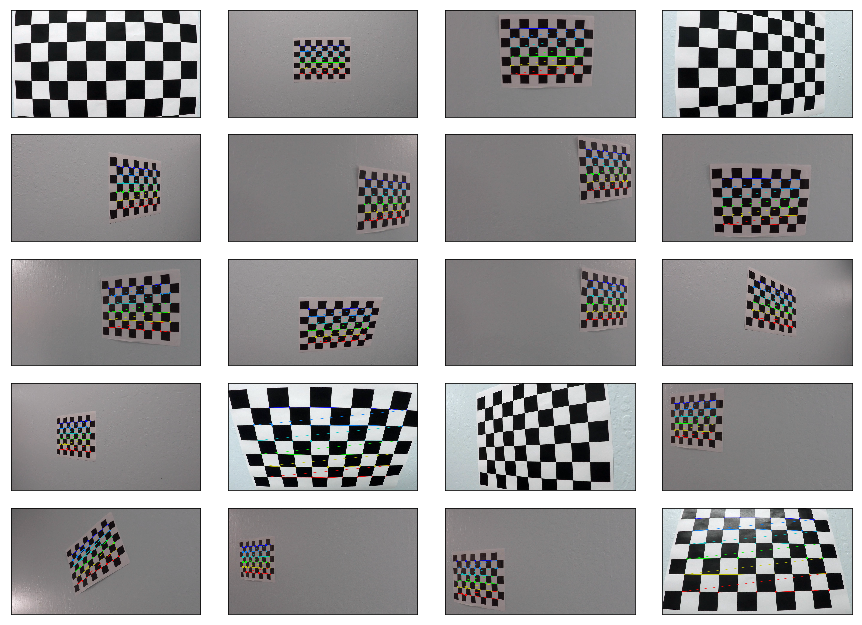

In [3]:
num_corners_x = 9
num_corners_y = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((num_corners_y*num_corners_x,3), np.float32)
objp[:,:2] = np.mgrid[0:num_corners_x, 0:num_corners_y].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('./camera_cal/calibration*.jpg')
drawn_checkboards = []
failed_cal_images = 0

# for each calibration image 
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # look for the corners
    ret, corners = cv2.findChessboardCorners(gray, (num_corners_x, num_corners_y), None)
    
    if ret:
        chk = cv2.drawChessboardCorners(img, (num_corners_x, num_corners_y), corners, ret)
        drawn_checkboards.append((chk, None))
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        drawn_checkboards.append((img, None))
        failed_cal_images += 1
        
print("Number of calibration images where corners could not be found: {0}".format(failed_cal_images))
tile_images(drawn_checkboards, 4)

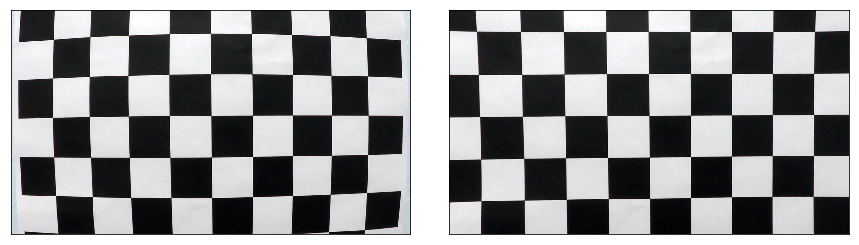

In [4]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)
images = [(img, None), (dst, None)]
tile_images(images, 2)

# Pipeline (test images)

### Example of a Distortion-Corrected Image

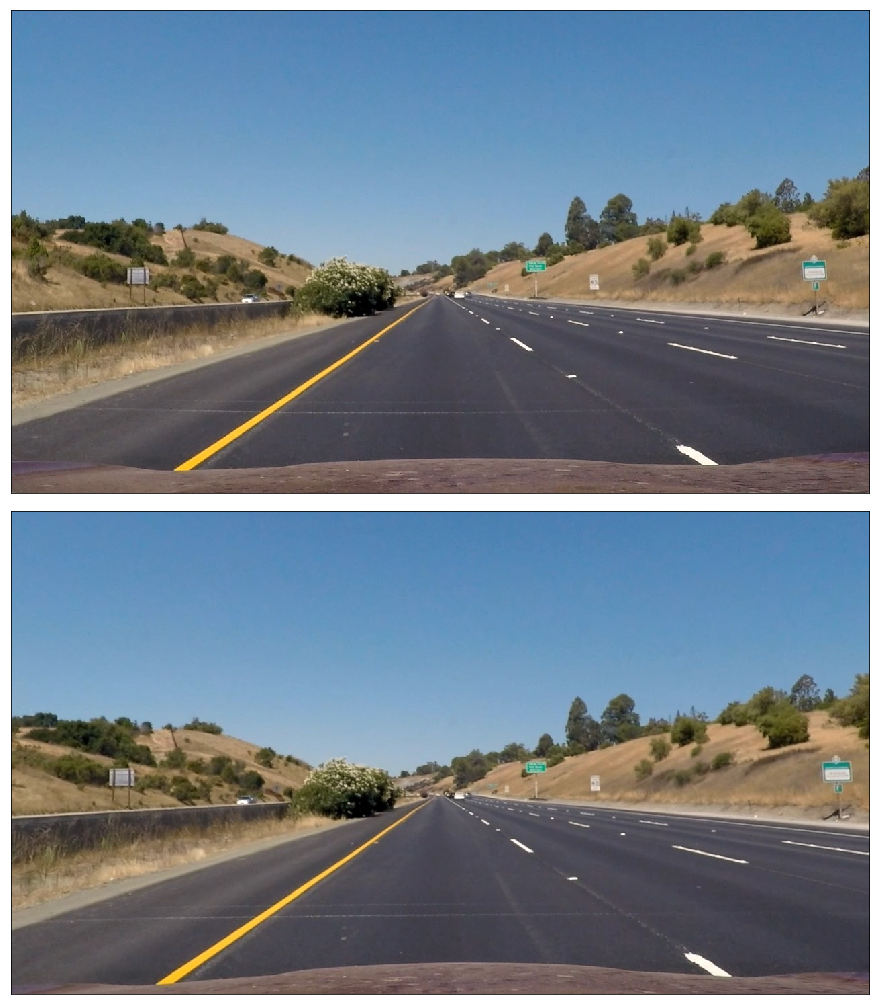

In [5]:
def undistort(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undst = undistort(img)

images = [(img, None), (undst, None)]
tile_images(images, 1)

### Binary Threshold on Example Images

#### Color Space and Masking

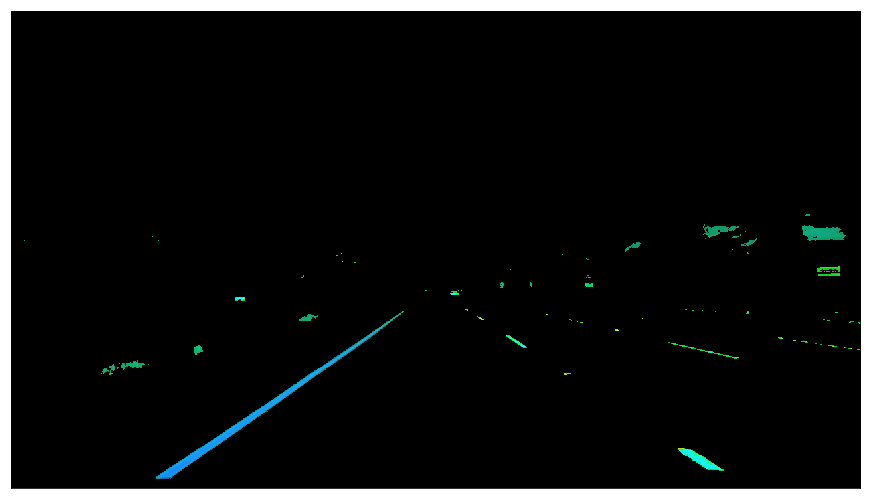

In [6]:
def set_color_space_and_mask_image(image, from_movie = False):
    # convert the image to the HLS color model so that the yellow color
    # can be defined invarient of shadows etc, for use in a color mask
    if from_movie:
        hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    else:
        hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)

    # mask the image to highlight yellow and white features
    masked = mask_colors_hls(hls)
    
    # convert the image after the mask to grayscale
    # image is in HLS space, not BGR, but grayscale just averages anyway
#     kernel_size = 3
#     blur = cv2.GaussianBlur(masked, (kernel_size, kernel_size), 0)
    
    return masked
    
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
tile_images([(masked, None)], 1)

#### Sobel Operators

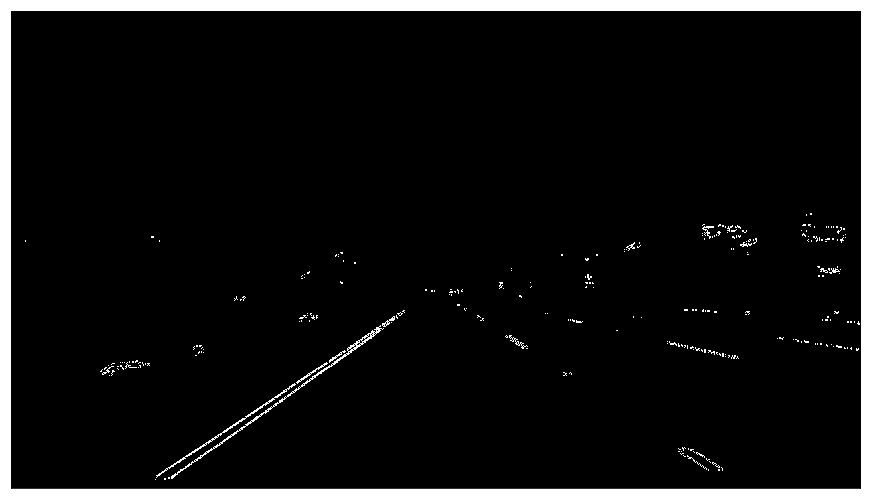

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # Return the result
    return binary_output

# Run the function
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
grad_binary = abs_sobel_thresh(masked, orient='x', thresh_min=20, thresh_max=100)
tile_images([(grad_binary, 'gray')], 1)

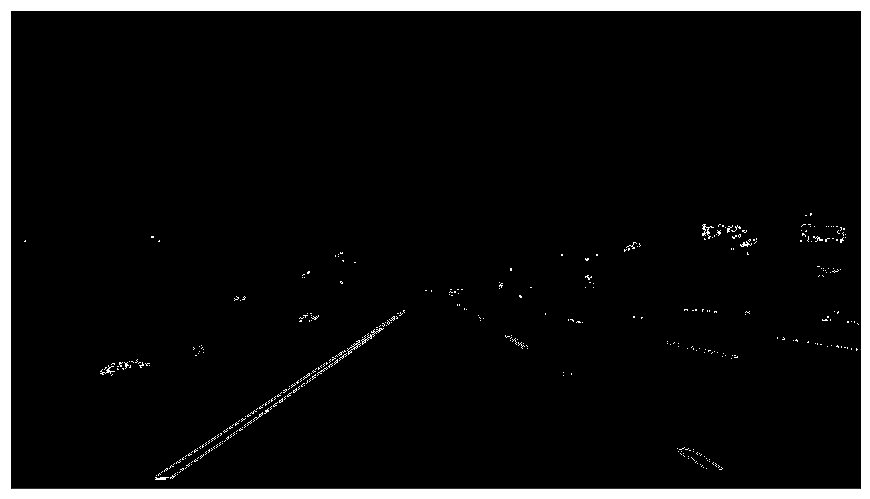

In [8]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
mag_binary = mag_thresh(masked, sobel_kernel=3, mag_thresh=(30, 100))
tile_images([(mag_binary, 'gray')], 1)

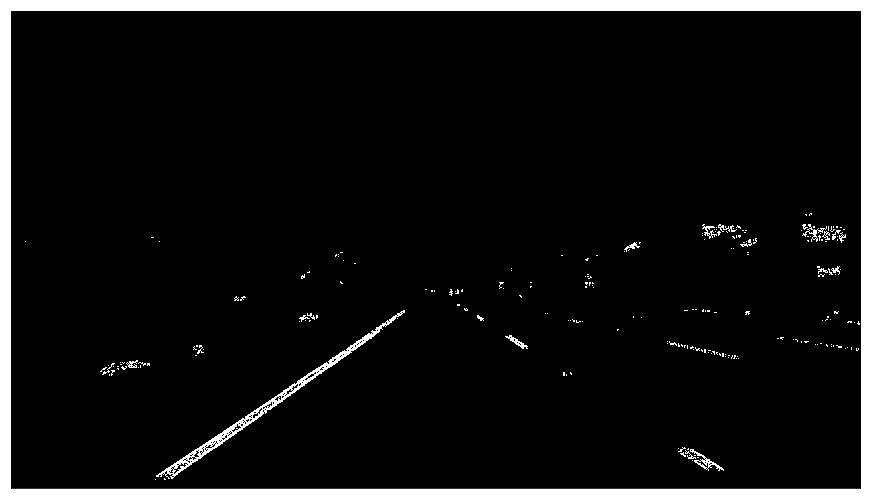

In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Run the function
img = cv2.imread('./test_images/straight_lines1.jpg')
dst = undistort(img)
masked = set_color_space_and_mask_image(dst)
dir_binary = dir_threshold(masked, sobel_kernel=3, thresh=(0.7, 1.3))
tile_images([(dir_binary, 'gray')], 1)

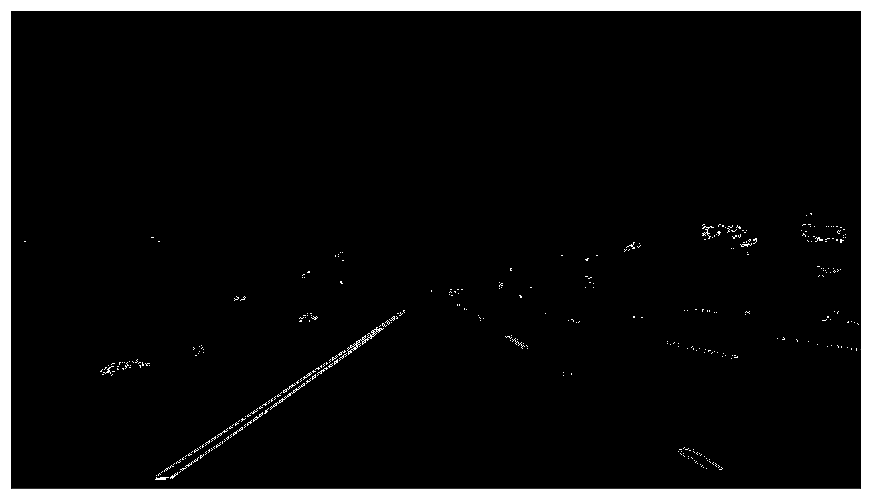

In [10]:
def get_binary_image(img):
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
    mag_sobel = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_sobel = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, np.pi/2))

    combined = np.zeros_like(dir_sobel)
    combined[((gradx == 1) & (grady == 1)) | ((mag_sobel == 1) & (dir_sobel == 1))] = 255
    # combined[((gradx == 1) & (grady == 1)) | ((mag_sobel == 1) & (dir_sobel == 1))] = 1
    # combined[((mag_sobel == 1) & (dir_sobel == 1))] = 1
    return combined
    
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
binary = get_binary_image(masked)
tile_images([(binary, 'gray')], 1)

### Perspective Transform

In [11]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

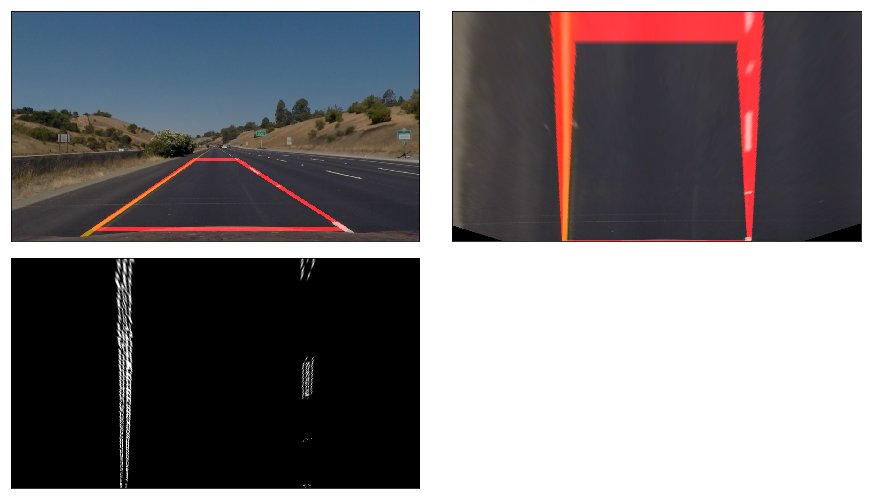

In [27]:
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
undst = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
h,w = undst.shape[:2]

# define source and destination points for transform

# src determined by tracing out parallel lines which vanish to the horizon in the original
# but which will be parallel to each other in the projection. The top boundry was selected 
# before the horizon starts to blur the tops of the lines. The bottom boundry was selected to 
# ignore the hood of the car
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

# y = mx + b
# m = y2-y1 / x2 - x1

# destination shape selected to map the trapaziod to the horizon to a square when looking
# down from a birds eye view. The size of the square was determined to mask out the extra 
# lane lines that could occur on either side of the ones we are interested in, while still 
# keeping curved lines in the frame
dst = np.float32([(350,0),
                  (w-350,0),
                  (350,h),
                  (w-350,h)])

# create an overlay of the source region
overlay = np.zeros_like(undst)
cv2.line(overlay,(575,464),(258,682),(255,0,0),10)
cv2.line(overlay,(258,682),(1049,682),(255,0,0),10)
cv2.line(overlay,(1049,682),(707,464),(255,0,0),10)
cv2.line(overlay,(575,464),(707,464),(255,0,0),10)
# Overlay the lines over the original image with some transparency
opacity = 0.7
img_with_lines = weighted_img(overlay, undst, α=opacity)

unwarped, M, Minv = unwarp(img_with_lines, src, dst)
unwarp_binary, M, Minv = unwarp(binary, src, dst)
    
tile_images([(img_with_lines, None),(unwarped, None), (unwarp_binary, 'gray')], 2)

### Apply Current Pipeline on Test Images (Unwrap First)

In [28]:
%%javascript
// Disable auto scroll in notebook for tests below
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

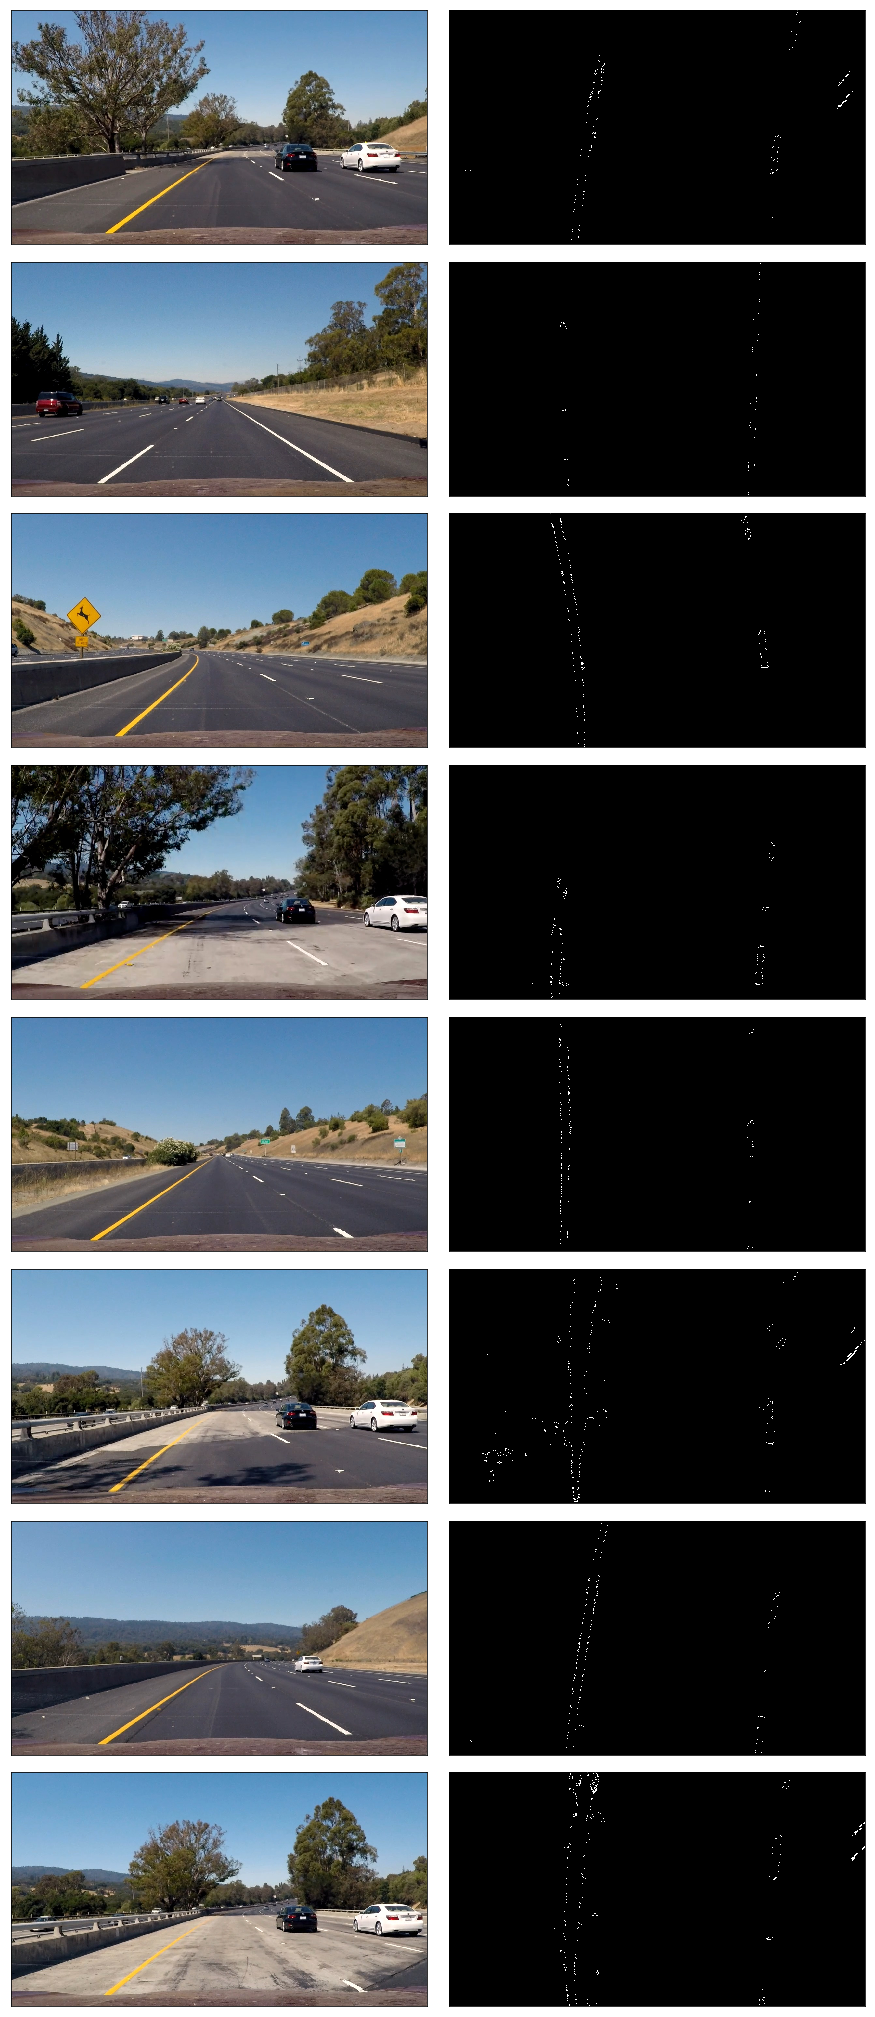

In [29]:
images = glob.glob('./test_images/test*.jpg')
images_to_draw = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    undst = undistort(img)
    unwarped, M, Minv = unwarp(undst, src, dst)
    masked = set_color_space_and_mask_image(unwarped)
    binary = get_binary_image(masked)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images_to_draw.append((img, None))
    images_to_draw.append((binary, 'gray'))

tile_images(images_to_draw, 2)

### Apply Current Pipeline on Test Images (Unwrap Last)

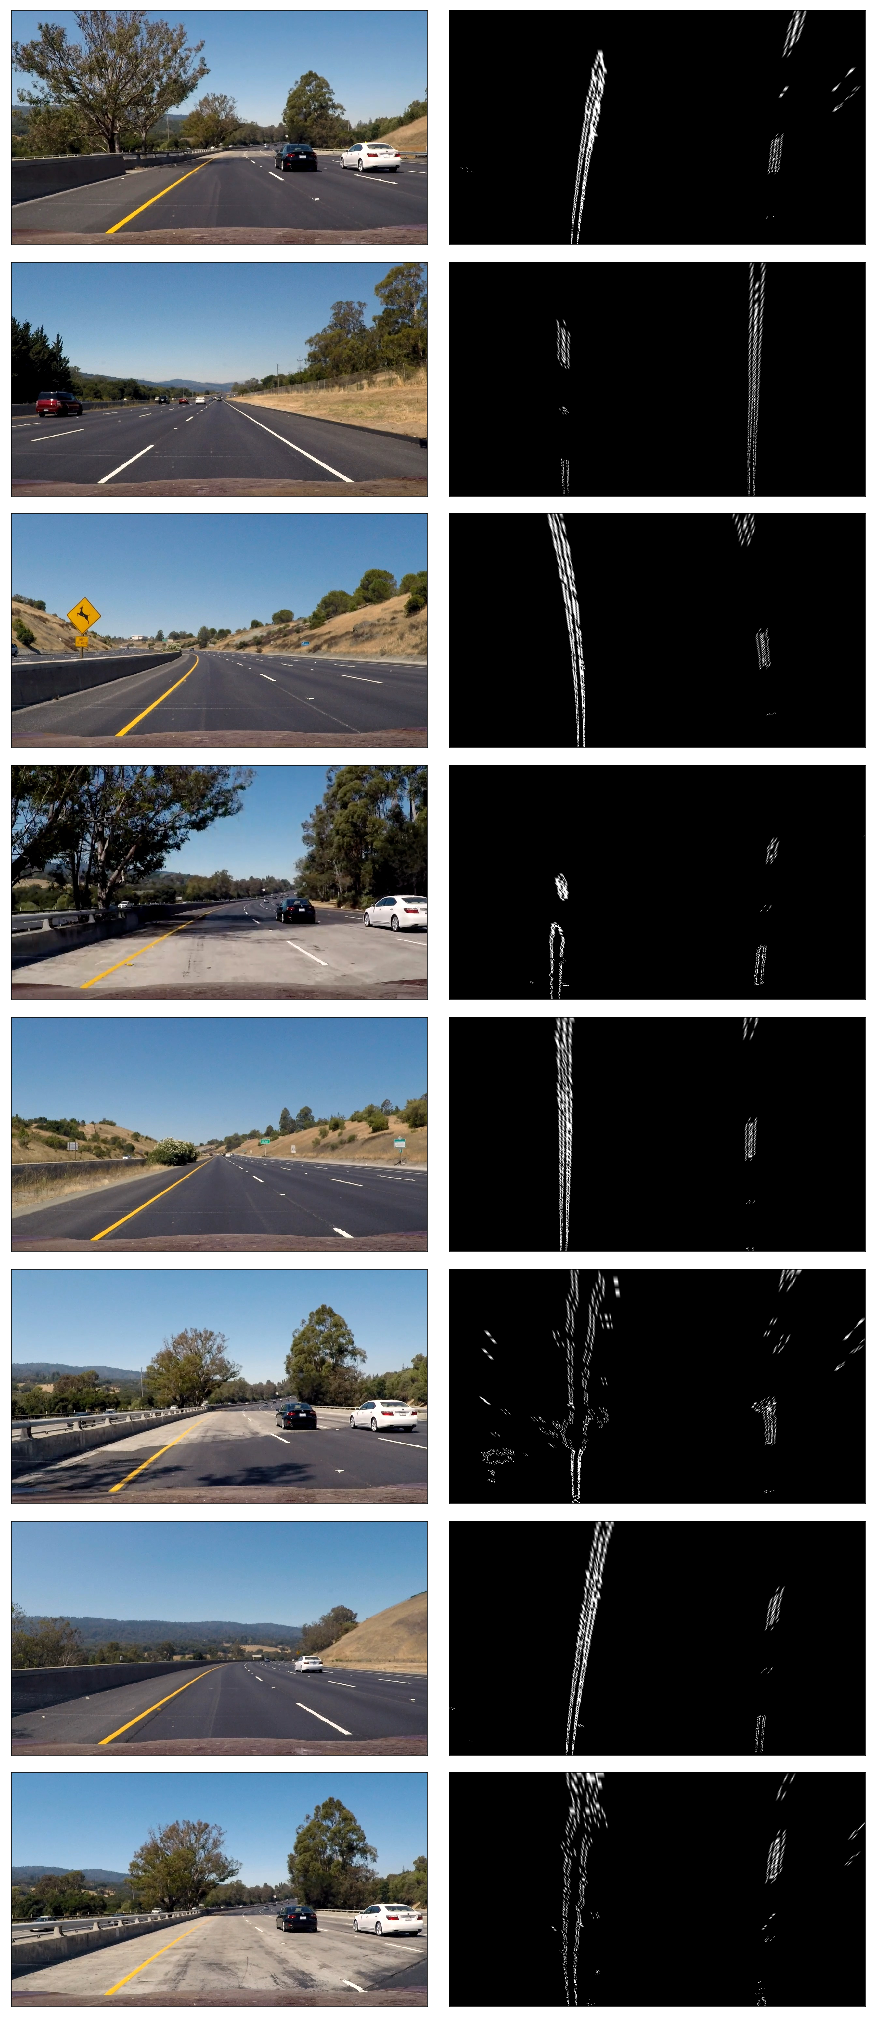

In [30]:
images = glob.glob('./test_images/test*.jpg')
images_to_draw = []
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    undst = undistort(img)
    masked = set_color_space_and_mask_image(undst)
    binary = get_binary_image(masked)
    unwarped, M, Minv = unwarp(binary, src, dst)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images_to_draw.append((img, None))
    images_to_draw.append((unwarped, 'gray'))

tile_images(images_to_draw, 2)

### Identify Lane Line Pixels

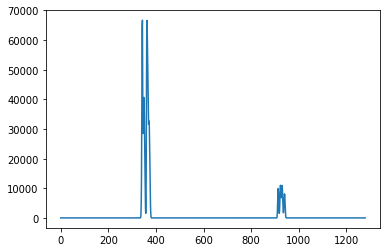

In [31]:
# proof of concept
img = cv2.imread('./test_images/straight_lines1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
binary = get_binary_image(masked)
unwarped, M, Minv = unwarp(binary, src, dst)
histogram = np.sum(unwarped[unwarped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

In [32]:
def identify_lane_pixels(lane_image, nwindows = 10):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(lane_image[lane_image.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(lane_image.shape[0]/nwindows)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangles = []
    
    nonzero = lane_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = lane_image.shape[0] - (window+1)*window_height
        win_y_high = lane_image.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high)) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit, right_fit = None, None
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    return rectangles, nonzerox, nonzeroy, left_fit, right_fit, left_lane_inds, right_lane_inds

#### Visualise Lane Pixel Identification

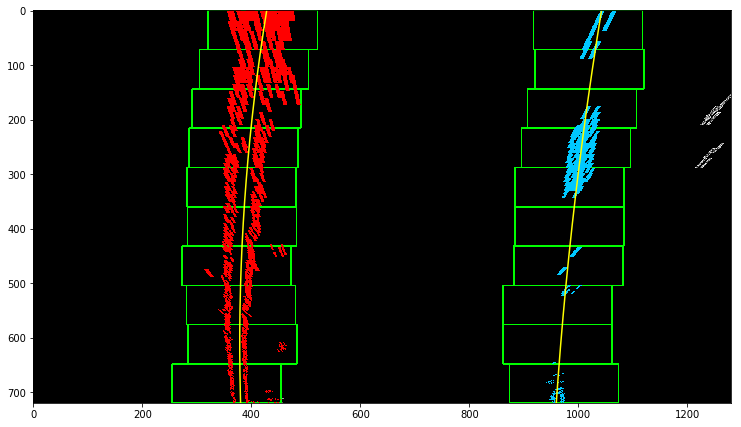

In [33]:
img = cv2.imread('./test_images/test1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
binary = get_binary_image(masked)
unwarped, M, Minv = unwarp(binary, src, dst)
rectangles, nonzerox, nonzeroy, left_fit, right_fit, left_lane_inds, right_lane_inds = identify_lane_pixels(unwarped)

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((unwarped, unwarped, unwarped))*255)
    
# Generate x and y values for plotting
ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2)

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 200, 255]

# figure size is specified in inches, so divide required pixel size by dots per inch
fig = plt.figure()
notebook_pixel_width = 900
dpi = fig.get_dpi()
fig.set_size_inches(notebook_pixel_width/float(dpi), (700)/float(dpi))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.show()

### Polyfit from previous frame

In [34]:
# test images 6,4 and 5 apear to be in chronological sequence

# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def polyfit_using_previous(lane_image, left_fit, right_fit, margin=100):
    nonzero = lane_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit_new, right_fit_new = None, None
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

#### Visualise Polyfit from Previous Lines

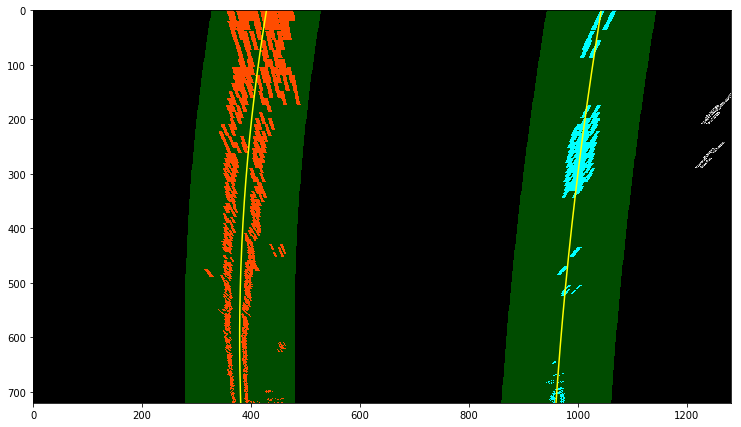

In [35]:
img = cv2.imread('./test_images/test1.jpg')
undst = undistort(img)
masked = set_color_space_and_mask_image(undst)
binary = get_binary_image(masked)
unwarped, M, Minv = unwarp(binary, src, dst)
margin = 100

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_previous(unwarped, left_fit, right_fit, margin)

nonzero = unwarped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Generate x and y values for plotting
ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )
left_fitx = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((unwarped, unwarped, unwarped))*255)
window_img = np.zeros_like(out_img)
    
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 200, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)



# figure size is specified in inches, so divide required pixel size by dots per inch
fig = plt.figure()
notebook_pixel_width = 900
dpi = fig.get_dpi()
fig.set_size_inches(notebook_pixel_width/float(dpi), (700)/float(dpi))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Calculate Radius of Curvature and Distance from Centre

In [36]:
def calculate_radius_and_dist(lane_image, ploty, leftx, rightx, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # max y value, bottom of image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    # The camera is in centre of car and therefore the centre of the image, i.e. midpoint of image width
    # The centre of the lane lines is the midpoint between their x intercepts, i.e. where they intersect the bottom
    # of the picture.
    if right_fit is not None and left_fit is not None:
        car_position = lane_image.shape[1]/2
        left_x_int = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
        right_x_int = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]
        lane_center = (right_x_int + left_x_int) /2
        dist = (car_position - lane_center) * xm_per_pix

    return left_curverad, right_curverad, dist


In [37]:
# Generate x and y values for plotting
ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )


left_curverad, right_curverad, dist = calculate_radius_and_dist(unwarped, ploty, left_fitx, right_fitx, left_fit, right_fit)
avg_curve = 0.5*(left_curverad + right_curverad)
print(avg_curve, 'm', dist, 'm')

1852.4446608 m -0.158584474549 m


### Project Lane Lines Back into Original Image

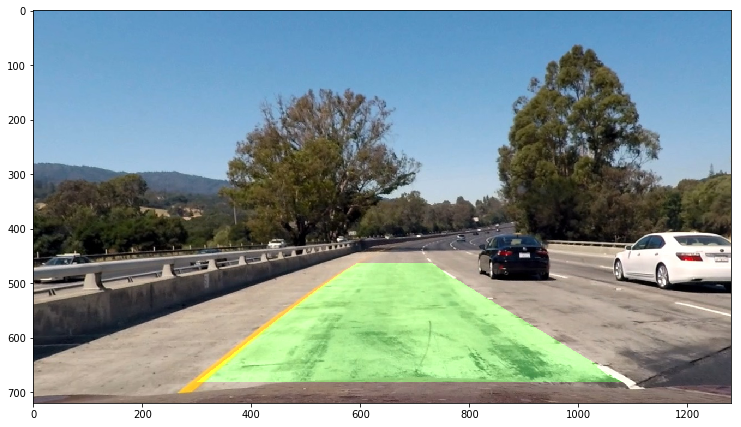

In [38]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(unwarped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

fig = plt.figure()
notebook_pixel_width = 900
dpi = fig.get_dpi()
fig.set_size_inches(notebook_pixel_width/float(dpi), (700)/float(dpi))
plt.imshow(result)
plt.show()

### Line Class for storing Data

In [169]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        self.n = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def add_fit(self, fit):
        if fit is not None:
            self.detected = True
            self.current_fit.append(fit)
            # truncate list of fits to size n
            self.current_fit = self.current_fit[-self.n:]
            self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # remove oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # calc best fit from remaining historical fits, if there are any
                self.best_fit = np.average(self.current_fit, axis=0)
        

### Process Image Pipeline

In [170]:

def process_image(frame, left_line, right_line):
    img = np.copy(frame)
    undst = undistort(img)
    masked = set_color_space_and_mask_image(undst, from_movie=True)
    binary = get_binary_image(masked)
    unwarped, M, Minv = unwarp(binary, src, dst)

    if not left_line.detected or not right_line.detected:
        rectangles, nonzerox, nonzeroy, left_fit, right_fit, left_lane_inds, right_lane_inds = identify_lane_pixels(unwarped)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous(unwarped, left_line.best_fit, right_line.best_fit)

    left_line.add_fit(left_fit)
    right_line.add_fit(right_fit)
    
    # draw the current best fit if it exists
    if left_line.best_fit is not None and right_line.best_fit is not None:
        # Create an output image to draw on and  visualize the result
        out_img = np.uint8(np.dstack((unwarped, unwarped, unwarped))*255)

        # Generate x and y values for plotting
        ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )
        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]

        # Create an image to draw the lines on
        warp_zero = np.zeros_like(unwarped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undst, 1, newwarp, 0.3, 0)
        
        ploty = np.linspace(0, unwarped.shape[0]-1, unwarped.shape[0] )
        left_curverad, right_curverad, dist = calculate_radius_and_dist(unwarped, ploty, left_fitx, right_fitx, left_line.best_fit, right_line.best_fit)
        left_line.radius_of_curvature = left_curverad
        left_line.line_base_pos = dist 
        right_line.radius_of_curvature = right_curverad
        right_line.line_base_pos = dist 
    else:
        result = img
        
    avg_curve = 0.5*(left_line.radius_of_curvature + right_line.radius_of_curvature)
    dist = left_line.line_base_pos
    
    h = result.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(avg_curve) + 'm'
    cv2.putText(result, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if dist > 0:
        direction = 'right'
    elif dist < 0:
        direction = 'left'
    abs_center_dist = abs(dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(result, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)

    return result

### Process Project Video

In [171]:
# Using some scope trickery to pass an extra few parameters to the frame processor
def process_image_wrapper(clip, left_line, right_line):
    def process_image_stateful(image):
        return process_image(image, left_line, right_line)
    
    return clip.fl_image(process_image_stateful)

In [173]:
left_line = Line(5)
right_line = Line(5)

video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
# video_input1 = VideoFileClip('project_video.mp4').subclip(0,5) # use subclip for shorter test video
processed_video = video_input1.fx(process_image_wrapper, left_line, right_line)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:25<00:00,  3.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 36min 51s, sys: 6.62 s, total: 36min 57s
Wall time: 5min 25s


### Process Challenge Video

In [134]:
left_line = Line(5)
right_line = Line(5)

video_output1 = 'project_video_output_challenge.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')
# video_input1 = VideoFileClip('challenge_video.mp4').subclip(0,5) # use subclip for shorter test video
processed_video = video_input1.fx(process_image_wrapper, left_line, right_line)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_challenge.mp4
[MoviePy] Writing video project_video_output_challenge.mp4



100%|██████████| 485/485 [02:10<00:00,  3.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_challenge.mp4 

CPU times: user 14min 13s, sys: 2.91 s, total: 14min 16s
Wall time: 2min 11s


### Process Harder Challenge Video

In [133]:
left_line = Line(5)
right_line = Line(5)

video_output1 = 'project_video_output_harder_challenge.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')
# video_input1 = VideoFileClip('harder_challenge_video.mp4').subclip(0,5) # use subclip for shorter test video
processed_video = video_input1.fx(process_image_wrapper, left_line, right_line)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output_harder_challenge.mp4
[MoviePy] Writing video project_video_output_harder_challenge.mp4



100%|█████████▉| 1199/1200 [05:36<00:00,  3.46it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_harder_challenge.mp4 

CPU times: user 35min 29s, sys: 6.3 s, total: 35min 36s
Wall time: 5min 37s
